In [1]:
!pip install transformers
!pip install datasets
# !pip install wandb



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip install xformers


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [40]:
import torch.nn as nn
import torch
from transformers import pipeline, set_seed
from transformers import GPT2Tokenizer


class MLP(nn.Module):
    ## multi layer perceptron thats inserted into distilgpt2
    ## function is simple, its 2 linear layers that take the output of the transformer in distilgpt2 and it learns to steer the text into making better prompts
    ## however, we only want to update parameters for the 2 linear layers, not the rest, hence the requires grad being set to false
    ## output of the lm_head in this case is our Q value
    ## lm_head outputs 50k size tensors, and it's argmax is the token that it represents (aka which word to pick out of the 50k vocab size)
    ## according to the paper, this 50k size tensor also represents Q value since it decides which word to pick for our prompt
    ## our 2 linear layers get fed in states aka the previous prompts that we've generated
    ## they learn the appropriate Q value that the lm_head should output for the action of picking a word based on current reward and discounted max future reward (aka the target)
    def __init__(self):
        super().__init__()
        self.lm_pipeline = pipeline('text-generation', model='distilgpt2')
        self.policy = nn.Sequential(
            nn.Linear(768, 2048),
            nn.ReLU(),
            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.Linear(2048, 768),
#             nn.ReLU(),
        )
        def _init_weights(m):
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.0001)
                m.bias.data.fill_(-0.0001)
        self.policy.apply(_init_weights)
        self.lm_pipeline.model.lm_head.requires_grad_(False)
        self.lm_pipeline.model.transformer.requires_grad_(False)
        self.lm_pipeline.model.lm_head = self.lm_pipeline.model.lm_head.to(device)
        self.lm_pipeline.model.transformer = self.lm_pipeline.model.transformer.to(device)
        self.tokenizer = GPT2Tokenizer.from_pretrained('distilgpt2', truncation_side = 'left')
        self.tokenizer.pad_token = self.tokenizer.eos_token
        self.lm_pipeline.model.train()
    def forward(self, x):
        # assert(x.shape[1] == 768)
        # print(x.shape)
        x = self.policy(x)
        return self.lm_pipeline.model.lm_head(x)
    def truncate(self, x):
        arr1 = []
        arr2 = []
        for i in x:
            token = self.tokenizer([i], return_tensors = 'pt')
            inp = token['input_ids'][0,-3:]
            masks = token['attention_mask'][0,-3:]
            arr1.append(inp)
            arr2.append(masks)
        return {'input_ids':torch.cat(arr1).reshape(len(x),-1), 'attention_mask': torch.cat(arr2).reshape(len(x),-1)}
            
    def get_lm_output(self, x):
        with torch.no_grad():
          input = self.truncate(x)
          for key, value in zip(input.keys(), input.values()):
            input[key] = value.to(device)
          return self.lm_pipeline.model.transformer(**input, use_cache=True).last_hidden_state
    def get_prompt(self, x):
        # print(x.shape)
        return  self.lm_pipeline.tokenizer.decode(x.softmax(-1).argmax(-1).reshape(1))
    def get_prompt_greedy(self, x, epsilon):
        # print(x.shape)
        if torch.rand(1) < epsilon:
            return  self.lm_pipeline.tokenizer.decode(torch.randint(0, x.shape[-1], (1,)))
        return  self.lm_pipeline.tokenizer.decode(x.softmax(-1).argmax(-1).reshape(1))
    def get_prompt_softmax_greedy(self, x):
        # print(x.shape)
        return  self.lm_pipeline.tokenizer.decode()
    

In [4]:
from transformers import pipeline

import torch
device = 'mps'

class MLM():
  ### Our masked LM model
  ### no learning involved here, just try to get the reward for having it fill it with good vs bad
  def __init__(self):
   self.unmasker = pipeline('fill-mask', model='distilroberta-base')

  def get_masked_word_class(self, input, prompt):
    return self.unmasker(f'{input} {prompt} <mask>', targets = ['good', 'bad'])




In [63]:

import torch
from tqdm import tqdm
# import wandb
### we have states which represents words that we feed into the distilgpt to get better words/prompts
### prompt at time t is a result of picking the action from the mlp that results in the highest reward
### can be written as argmax(reward(MLP(states)), arg = prompt)
### our loss/regression target is essentially reward+discount*max(Q(s_t+1, a'_t+1) for all a')
### this technically isn't the softqlearner, and is generally unstable and produces sparse rewards and takes an extremely long time to train
class QLearner():

    def __init__(self):
        self.mlm = MLM()
        self.mlp = MLP().to(device)
        self.target = MLP().to(device)
#         self.target.load_state_dict(self.mlp.state_dict())
        # torch.manual_seed(95)

        self.last_state = 'this'
        self.prompt_reward = [0]
        self.max_reward = 0
        self.optimizer = torch.optim.AdamW(self.mlp.parameters(), lr=1e-4)
        self.accuracy = []
        self.val_acc = []
        self.loss_ = []
        self.epsilon = .9
    def randomize(self, Q, epsilon): 
#         print("max, min ", Q.max(), Q.min())
        r = torch.rand(1)
#         print('before')
#         print(Q.argmax(-1))
        if r < epsilon:
            index = torch.randint(0, Q.shape[-1], (1,))
            
            m = Q.max().item()
            m = 1 if m == 0 else m
            detached = Q.detach()
#             print('index and max prob',index,m)
            detached[:] = 0
            detached[index] = m
#             print('prob:',r)
#         print('after')
#         print(Q.argmax(-1))
        return Q
    # gets the actions for every state, and their Q values. actions in this case are the prompts
    def get_actions_Q (self, last_state):
        actions = []
        Q = []
        for i in range(5):
          lm_output = self.mlp.get_lm_output([last_state]).to(device) 
          Q_ = self.mlp(lm_output)
          Q.append(Q_)
          last_state = self.mlp.get_prompt(Q_)
          actions.append(last_state)
        if type(actions) == str:
          actions = [actions]
        return actions, torch.cat(Q), last_state

    def get_actions_Q_target (self, last_state):
        actions = []
        Q = []
        for i in range(5):
          lm_output = self.target.get_lm_output([last_state]).to(device) 
          Q_ = self.target(lm_output)
          Q.append(Q_)
          last_state = self.target.get_prompt(Q_)
          actions.append(last_state)
        if type(actions) == str:
          actions = [actions]
        return actions, torch.cat(Q), last_state


    def get_actions_Q_input_specific (self, batch_input):
        actions = []
#         print(len(batch_input))
        lm_output = self.mlp.get_lm_output(batch_input).to(device) 
        Q_ = self.mlp(lm_output)
    
#         print(Q_.shape)
        Q_ = Q_[:,-1].reshape(Q_.shape[0], Q_.shape[-1]) #(16, 50k)
        for i in range(Q_.shape[0]):
          actions.append([self.mlp.get_prompt(Q_[i])])
        
        Q = [[self.randomize(Q_[i], self.epsilon).reshape(1, Q_.shape[-1])] for i in range(Q_.shape[0])]



        for i in range(4):
          lm_output = self.mlp.get_lm_output([ batch_input[j]+"".join(actions[j]) for j in range(len(actions))]).to(device) 
          Q_ = self.mlp(lm_output)
        
          Q_ = Q_[:,-1].reshape(Q_.shape[0], Q_.shape[-1])
          for j in range(Q_.shape[0]):
            Q[j].append(self.randomize(Q_[j], self.epsilon).reshape(1, Q_.shape[-1]))
          
          for j in range(Q_.shape[0]):
            actions[j].append(self.mlp.get_prompt(Q_[j]))
        if type(actions) == str:
          actions = [actions]
        # print(Q)
        # print(actions)
        Q = [torch.cat(Q__).reshape(1,5,-1) for Q__ in Q]
        # print(torch.cat(Q).shape)
        return actions, torch.cat(Q)

    def get_actions_Q_input_specific_target (self, batch_input):
        actions = []

        lm_output = self.target.get_lm_output(batch_input).to(device) 
        Q_ = self.target(lm_output)
        Q_ = Q_[:,-1].reshape(Q_.shape[0], Q_.shape[-1])
        for i in range(Q_.shape[0]):
          actions.append([self.mlp.get_prompt(Q_[i])])
        Q = [[Q_[i].reshape(1, Q_.shape[-1])] for i in range(Q_.shape[0])]



        for i in range(4):
          lm_output = self.mlp.get_lm_output([batch_input[j]+"".join(actions[j]) for j in range(len(actions))]).to(device) 
          Q_ = self.target(lm_output)
          Q_ = Q_[:,-1].reshape(Q_.shape[0], Q_.shape[-1])
          for j in range(Q_.shape[0]):
            Q[j].append(Q_[j].reshape(1, Q_.shape[-1]))
          
          for j in range(Q_.shape[0]):
            actions[j].append(self.mlp.get_prompt(Q_[j]))
        if type(actions) == str:
          actions = [actions]

        Q = [torch.cat(Q__).reshape(1,5,-1) for Q__ in Q]
        # for i in Q:
        #   for j in i:
        #     print(j.shape)
        # print(torch.cat(Q).shape)
        return actions, torch.cat(Q)

    # to be updated but currently the reward is set to how many correct classifications can this model make
    def get_reward(self, train_x, train_y, prompt):
        reward = 0
        count = 0
        
        for sentence, cls in zip(train_x, train_y):
                word_cls = self.mlm.get_masked_word_class(sentence, prompt)
#                 if (word_cls[0]['token_str'] == 'good' and cls == 1) or (word_cls[0]['token_str'] == 'bad' and cls == 0):
#                     reward = 
#                 else:
#                     incorrect +=1
                if (word_cls[0]['token_str'] == 'good' and cls == 1) or (word_cls[0]['token_str'] == 'bad' and cls == 0):
                    reward += (word_cls[0]['score']- word_cls[1]['score'])
                else:
                    reward += (word_cls[1]['score']- word_cls[0]['score'])
                count +=1
        return reward/count
    def get_accuracy(self, train_x, train_y, prompt):
        count = 0
        accurate = 0
        for sentence, cls in zip(train_x, train_y):
                word_cls = self.mlm.get_masked_word_class(sentence, prompt)
                if (word_cls[0]['token_str'] == 'good' and cls == 1) or (word_cls[0]['token_str'] == 'bad' and cls == 0):
                    reward = word_cls[0]['score']- word_cls[1]['score']
                else:
                    reward = word_cls[1]['score']- word_cls[0]['score']
                count +=1
                accurate = accurate + 1 if reward >0 else accurate
        return accurate/count
  
    def loss(self, train_x, train_y):

        actions, Q = self.get_actions_Q_input_specific(train_x)
#         print(Q.shape)
        reward = torch.tensor([self.get_reward(train_x, train_y, ' '.join(action)) for action in actions]).to(device)
        accuracy = torch.tensor([self.get_accuracy(train_x, train_y, ' '.join(action)) for action in actions])
#         reward = high_reward*2-1
#         reward = high_reward
        if reward.std() > 1e-3:
            reward = (reward-reward.mean())/reward.std()
        reward = (200**(reward>0))*(100**(reward<=0))*reward
        with torch.no_grad():
          actions_, Q_, = self.get_actions_Q_input_specific_target(train_x)
        return torch.nn.functional.mse_loss(\
            Q, \
            reward.reshape(-1,1,1)+\
            0.99*Q_.detach()), accuracy, [' '.join(action) for action in actions]
    
    def get_accuracy_(self, val_x, val_y, prompts):
#         print(prompts)
        return torch.tensor([self.get_accuracy(val_x, val_y, prompt) for prompt in prompts]).mean()


    def train(self, train_x, train_y, val_x, val_y, epochs):
        
        for i in tqdm(range(epochs)):
            self.optimizer.zero_grad()
            loss, reward, prompts = self.loss(train_x, train_y)
            loss.backward()
            self.optimizer.step()
#             train_accuracy = self.get_accuracy_(train_x, train_y, prompts)
#             val_accuracy = self.get_accuracy_(val_x, val_y, prompts)
            self.accuracy.append(reward.mean())
            self.loss_.append(loss.item())
            
            if i %30 == 0:
                self.epsilon = self.epsilon*.9
            
            if i %10==0:
              target_weights = self.target.state_dict()
              for key in target_weights:
                target_weights[key] = self.mlp.state_dict()[key] 
              self.target.load_state_dict(target_weights)
              
              val_accuracy = self.get_accuracy_(val_x, val_y, prompts)
              self.val_acc.append(val_accuracy)
              print(f'loss:{loss.item()}, train_acc: {reward.mean()}, val_acc: {val_accuracy}')
              print(f'prompts: {prompts}')
#               wandb.log({"train_acc": reward.mean(), "val_accuracy": val_accuracy, 'prompts':prompts })
            

In [114]:

ql = QLearner()

In [143]:
import pandas as pd
train_x = list(pd.read_csv('yelp_train')['text'].apply(lambda x: x[:1000]))
train_y = list(pd.read_csv('yelp_train')['label'])

# train_x = train_x + train_x[-4:]
# train_y = train_y[:4] + train_y[-4:]
val_x = list(pd.read_csv('yelp_val')['text'].apply(lambda x: x[:1000]))
val_y = list(pd.read_csv('yelp_val')['label'])

In [144]:
import random

# # start a new wandb run to track this script
# wandb.init(
#     # set the wandb project where this run will be logged
#     project="DQN RLPrompt LOCAL MPS",
    
#     # track hyperparameters and run metadata
#     config={
#     "learning_rate": 1e-4,
#     "architecture": "DQN",
#     "dataset": "sst",
#     "epochs": 2999,
#     }
# )
ql.train(train_x, train_y, val_x, val_y, epochs = 2999)

  0%|                                   | 1/2999 [03:19<166:06:16, 199.46s/it]

loss:0.351494699716568, train_acc: 0.638671875, val_acc: 0.5322265625
prompts: ['�� �� �� �� ��', '�� �� ��  unb  Cald', '�� �� �� �� ��', '�� �� �� �� ��', '�� �� ��  satisf ��', '�� �� 661 ��  referencing', '�� �� �� �� ��', '�� �� �� �� ��', '�� �� �� �� ��', '��  Metro  marching �� ��', '��  mantra �� �� ��', '�� �� ��  band akes', '��  Barton ��  accessing ��', '��  Ted �� �� ��', '�� �� eni ock scoring', '�� ��  circadian �� ��', '�� �� �� �� ident', '�� �� �� �� ��', '��  AL ��  lesbians ��', '�� UPDATE �� �� ��', '�� �� �� �� ubric', '�� �� �� �� ��', '�� �� �� 438 519', '�� �� �� �� ��', '��  2007 �� �� ��', '�� ipples  slavery �� ��', '�� �� �� �� ��', '�� �� otherapy �� ��', '�� �� �� �� ��', '�� �� �� �� ��', '�� ��  inaccurate �� ��', '�� �� ��  NEWS ��']


  0%|                                  | 11/2999 [27:51<139:16:54, 167.81s/it]

loss:0.29563039541244507, train_acc: 0.662109375, val_acc: 0.5322265625
prompts: ['��  subord �� �� ��', '�� �� �� �� ��', '�� �� �� �� ��', '�� �� ��  257 ��', '��  revel �� �� ��', '�� ��  avoided ETHOD  dominated', '�� �� �� �� ��', '�� �� �� �� ��', '��  Monument ��  shaft ��', '�� �� �� ��  electromagnetic', '�� �� �� Furthermore ��', '�� �� �� �� ��', '��  Romania �� �� ��', '�� �� ��  STL ��', '�� ��  implications VERS ��', '�� �� ��  Ober ouf', '�� �� �� �� ��', '�� �� �� �� ��', '�� �� �� �� ��', '�� �� �� �� ��', '�� �� �� �� ��', '�� �� �� �� ��', '�� Collect �� �� ��', '�� �� �� �� ��', '�� �� �� GM ��', '�� �� �� �� ��', '�� ��  Bol  pitcher ��', '��  defenses �� �� ��', '��  Bran rex �� ��', '�� ��  Drop ollar ��', '�� ��  Estonia �� ��', '�� �� �� �� ��']


  0%|                                  | 11/2999 [28:48<130:26:44, 157.16s/it]


KeyboardInterrupt: 

Text(0, 0.5, 'Train Accuracy')

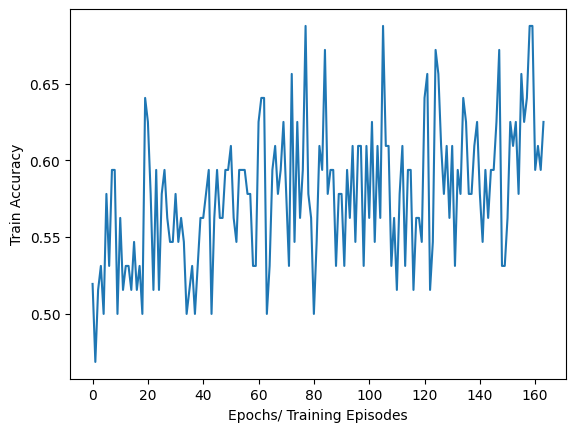

In [126]:
import matplotlib.pyplot as plt

plt.plot([i for i in range(len(ql.accuracy))], ql.accuracy)
plt.xlabel('Epochs/ Training Episodes')
plt.ylabel('Train Accuracy')
## next attempt: try putting the new token into target since it should be the future action thats being compared


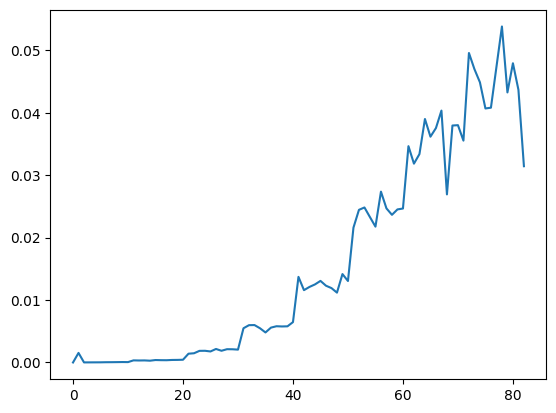

In [74]:
import matplotlib.pyplot as plt

plt.plot([i for i in range(len(ql.loss_))], ql.loss_)

## next attempt: try putting the new token into target since it should be the future action thats being compared

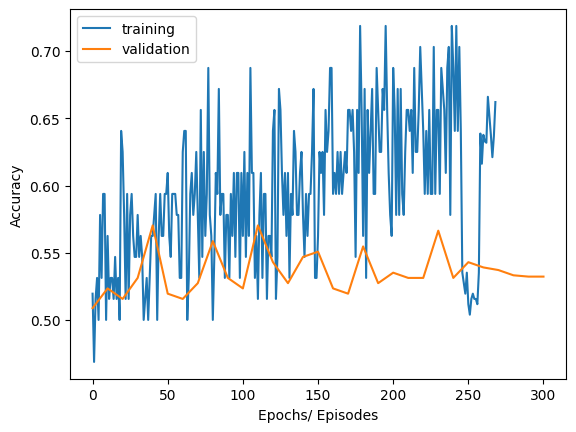

In [145]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(len(ql.accuracy))], ql.accuracy, label = 'training')
plt.plot([i*10 for i in range(len(ql.val_acc))], ql.val_acc, label = 'validation')
plt.xlabel('Epochs/ Episodes')
plt.ylabel('Accuracy')
plt.legend()
## next attempt: try putting the new token into target since it should be the future action thats being compared

In [147]:
test_x = list(pd.read_csv('yelp_test')['text'].apply(lambda x: x[:1000]))
test_y = list(pd.read_csv('yelp_test')['label'])

with torch.no_grad():
    prompts, Q = ql.get_actions_Q_input_specific_target(val_x)
#     accuracy = ql.get_accuracy_(test_x, test_y, [' '.join(prompt) for prompt in prompts])

In [139]:
print(ql.get_accuracy_(test_x, test_y, [' '.join(prompt) for prompt in prompts][1]))

KeyboardInterrupt: 